In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dabest
import seaborn as sns
from scipy.stats import bootstrap, ttest_1samp, spearmanr
import matplotlib.gridspec as gridspec
import ptitprince as pt
import os

from bids import BIDSLayout
from eeg_positions import get_elec_coords
import mne

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [2]:
if not os.path.exists('figures'):
    os.mkdir('figures')

def savefig(fname):
    fpath = os.path.join('figures', fname)
    plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')

In [3]:
layout = BIDSLayout('bids_dataset', derivatives = True)

/home/johnv/miniforge3/envs/agency-battery/lib/python3.9/site-packages/bids/layout/validation.py:124: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
xcorrs = [f.get_dict() for f in layout.get(suffix = 'xcorr')]
subs = [f.entities['subject'] for f in layout.get(suffix = 'xcorr')]
xcorrs = pd.DataFrame(xcorrs)
xcorrs['subject'] = subs
scr = pd.DataFrame([f.get_dict() for f in layout.get(desc = 'decoding', suffix = 'score')])
print('median cross-validated correlation score:', scr.eggOnsets.median())
xcorrs['score'] = (scr.eggOnsets > scr.eggOnsets.median()).replace({True: '(high corr)', False: '(low corr)'})
post2pre = xcorrs[['subject', 'post->pre', 'score']]
post2pre.columns = ['subject', 'lag', 'score']
post2pre['block'] = r'post$\rightarrow$pre'
pre2post = xcorrs[['subject', 'pre->post', 'score']]
pre2post.columns = ['subject', 'lag', 'score']
pre2post['block'] = r'pre$\rightarrow$post'
df = pd.concat([post2pre, pre2post])
xcorrs['score'] = scr.eggOnsets
xcorrs.head()

median cross-validated correlation score: 0.12762080806291587


,pre->post,post->pre,subject,score
0,0.000000,-0.007143,01,0.082398
1,-0.021429,-0.007143,02,0.123678
2,0.000000,0.000000,03,0.151377
3,0.014286,-0.014286,04,0.153630
4,0.000000,0.000000,05,0.143152


In [5]:
df.head()

,subject,lag,score,block
0,01,-0.007143,(low corr),post$\rightarrow$pre
1,02,-0.007143,(low corr),post$\rightarrow$pre
2,03,0.000000,(high corr),post$\rightarrow$pre
3,04,-0.014286,(high corr),post$\rightarrow$pre
4,05,0.000000,(high corr),post$\rightarrow$pre


In [6]:
# jitter (only for visualization), so zero lag subjects 
# don't hide behind the dashed line we draw over zero (or behind each other)
np.random.seed(0)
df['lag of predicted onsets (s)'] = df.lag + np.random.normal(0, .0005, size = df.shape[0])
data = dabest.load(
    data = df, 
    x = ['block', 'subject'], y = 'lag of predicted onsets (s)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'score',
    random_seed = 0,
    delta2 = True,
)


In [7]:
def get_ci(block, score):
    lags = df.lag[(df.block == block) & (df.score == score)]
    ci = bootstrap([lags.to_numpy()], np.mean, method = 'basic', random_state = 0, confidence_level = .95)
    return lags.mean(), ci.confidence_interval

mean = 0.002 [-0.003, 0.007]
mean = -0.003 [-0.008, 0.001]
mean = -0.003 [-0.005, 0.000]
mean = 0.003 [0.000, 0.005]


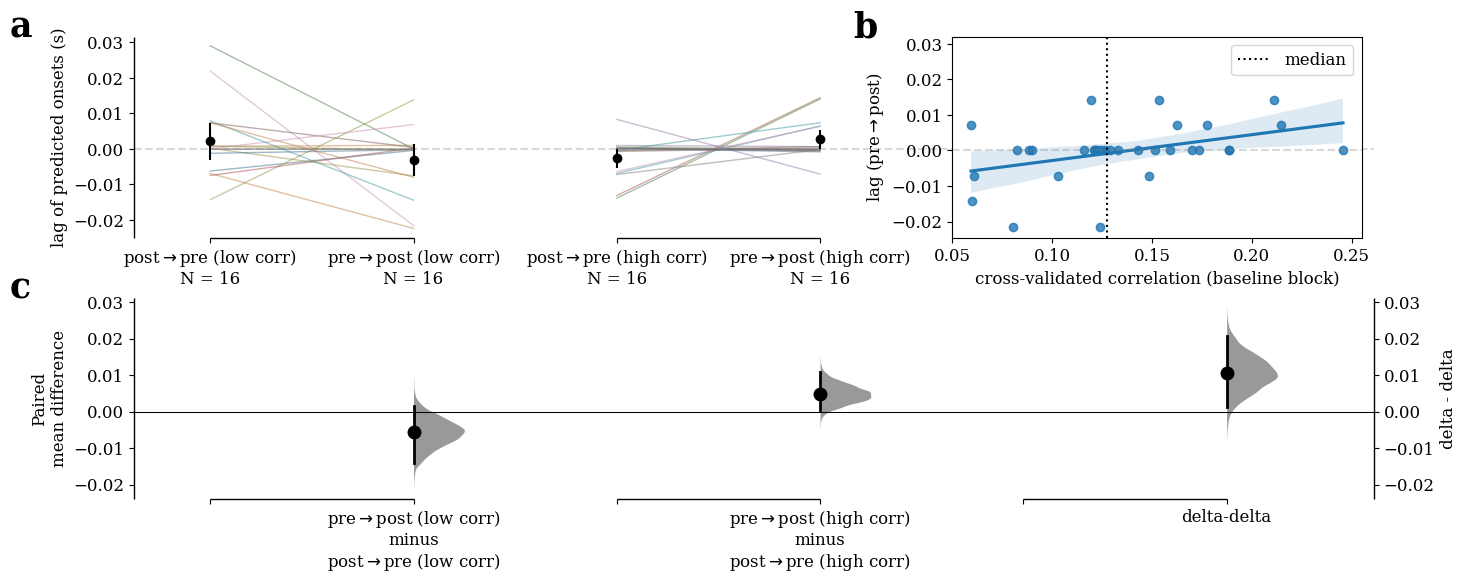

In [8]:
def add_label(ax, label, x_offset = -.19, y_offset = .0):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = 25, weight = 'bold'
    )

fig, ax = plt.subplots(figsize = (16, 6))
data.mean_diff.plot(ax = ax)
ax.axhline(0, color = 'gray', linestyle = '--', alpha = .3)
m, ci = get_ci(r'post$\rightarrow$pre', '(low corr)')
print('mean = %.03f [%.03f, %.03f]'%(m, ci[0], ci[1]))
ax.vlines(0, ci[0], ci[1], color = 'black')
ax.scatter(0, m, color = 'black')
m, ci = get_ci(r'pre$\rightarrow$post', '(low corr)')
print('mean = %.03f [%.03f, %.03f]'%(m, ci[0], ci[1]))
ax.vlines(1, ci[0], ci[1], color = 'black')
ax.scatter(1, m, color = 'black')
m, ci = get_ci(r'post$\rightarrow$pre', '(high corr)')
print('mean = %.03f [%.03f, %.03f]'%(m, ci[0], ci[1]))
ax.vlines(2, ci[0], ci[1], color = 'black')
ax.scatter(2, m, color = 'black')
m, ci = get_ci(r'pre$\rightarrow$post', '(high corr)')
print('mean = %.03f [%.03f, %.03f]'%(m, ci[0], ci[1]))
ax.vlines(3, ci[0], ci[1], color = 'black')
ax.scatter(3, m, color = 'black')
ax.get_legend().remove()

add_label(ax, 'a', x_offset = -.1)
add_label(ax, 'c', x_offset = -.1, y_offset = -1.3)
add_label(ax, 'b', x_offset = .58)

xmin, xmax = ax.get_xlim()
xrange = np.abs(xmin - xmax)
ymin, ymax = ax.get_xlim()
yrange = np.abs(ymin - ymax)
axin = ax.inset_axes([.66, 0, .33, 1])
sns.regplot(data = xcorrs, x = 'score', y = 'pre->post', ax = axin)
axin.axhline(0, color = 'gray', linestyle = '--', alpha = .3)
axin.axvline(xcorrs.score.median(), color = 'black', linestyle = 'dotted', label = 'median')
axin.set_ylim(-.0245, .032)
axin.set_xlabel('cross-validated correlation (baseline block)')
axin.set_ylabel(r'lag (pre$\rightarrow$post)')
axin.legend()

savefig('xcorr.jpeg')
plt.show()

In [9]:
# this was our a priori hypothesis so we can use one-sided p-values
lags = df.lag[(df.block == r'pre$\rightarrow$post') & (df.score == '(high corr)')]
ttest_1samp(lags, popmean = 0, alternative = 'greater')

Ttest_1sampResult(statistic=1.8605210188381265, pvalue=0.04126535317348113)

In [10]:
lags = df.lag[(df.block == r'post$\rightarrow$pre') & (df.score == '(high corr)')]
ttest_1samp(lags, popmean = 0, alternative = 'less')

Ttest_1sampResult(statistic=-1.860521018838127, pvalue=0.041265353173481116)

In [11]:
# we do have an a priori hypothesis that this should be positive, but we
# would also interpret a negative correlation as evidence against a 
# movement artifact even if it doesn't align with our hypothesis,
# so this is a two-tailed test
spearmanr(xcorrs.score, xcorrs['pre->post'], alternative = 'two-sided')

SpearmanrResult(correlation=0.40995921553856773, pvalue=0.01979059610587903)

In [12]:
# compute confidence intervals with non-jittered lags 
data = dabest.load(
    data = df, 
    x = ['block', 'subject'], y = 'lag', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'score',
    random_seed = 10,
    delta2 = True,
)
data.mean_diff.statistical_tests[['control', 'test', 'control_N', 'ci', 'bca_low', 'bca_high']] 

/home/johnv/miniforge3/envs/agency-battery/lib/python3.9/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/johnv/miniforge3/envs/agency-battery/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,control,test,control_N,ci,bca_low,bca_high
0,post$\rightarrow$pre (low corr),pre$\rightarrow$post (low corr),16,95,-0.013839,0.001786
1,post$\rightarrow$pre (high corr),pre$\rightarrow$post (high corr),16,95,0.000446,0.011161


In [13]:
# two-sided p-values
data.mean_diff

DABEST v2023.2.14
                 
Good afternoon!
The current time is Wed Jul 10 14:10:08 2024.

The paired mean difference for repeated measures against baseline 
between post$\rightarrow$pre (low corr) and pre$\rightarrow$post (low corr) is -0.00536 [95%CI -0.0138, 0.00179].
The p-value of the two-sided permutation t-test is 0.177, calculated for legacy purposes only. 

The paired mean difference for repeated measures against baseline 
between post$\rightarrow$pre (high corr) and pre$\rightarrow$post (high corr) is 0.00536 [95%CI 0.000446, 0.0112].
The p-value of the two-sided permutation t-test is 0.0466, calculated for legacy purposes only. 

The delta-delta between (low corr) and (high corr) is 0.0107 [95%CI 0.000893, 0.0201].
The p-value of the two-sided permutation t-test is 0.049, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect s

In [14]:
# p-values here are two-sided
data.mean_diff.statistical_tests[['control', 'test', 'difference', 'ci', 'bca_low', 'bca_high', 'pvalue_permutation']]

,control,test,difference,ci,bca_low,bca_high,pvalue_permutation
0,post$\rightarrow$pre (low corr),pre$\rightarrow$post (low corr),-0.005357,95,-0.013839,0.001786,0.1774
1,post$\rightarrow$pre (high corr),pre$\rightarrow$post (high corr),0.005357,95,0.000446,0.011161,0.0466


In [15]:
# construct mne.Info object with channel positions
evoked = mne.read_evokeds(layout.get(subject = '11', suffix = 'ave')[0].path)[0]
raw = mne.io.read_raw(layout.get(scope = 'PREP', extension = 'fif.gz')[0].path)
coords = get_elec_coords(as_mne_montage = True)
raw = raw.set_montage(coords)
raw = raw.pick(evoked.ch_names)
info = raw.info

def plot_topo(scr, p, vlim, ax):
    max_delta = np.abs(scr).max()
    return mne.viz.plot_topomap(
        scr,
        pos = info,
        mask = p < .05,
        axes = ax,
        show = False,
        vmin = -vlim,
        vmax = vlim
    )

In [16]:
scores_w = [np.load(f.path) for f in layout.get(desc = 'encodingWithEGGOnsets', suffix = 'score')]
scores_w = np.stack(scores_w)
scores_w_Z = np.arctanh(scores_w)  # Fisher's z-transform
scores_wo = [np.load(f.path) for f in layout.get(desc = 'encodingWithoutEGGOnsets', suffix = 'score')]
scores_wo = np.stack(scores_wo)
scores_wo_Z = np.arctanh(np.stack(scores_wo))
scores = scores_w - scores_wo
scores = np.median(scores, 0)
scores_w = np.median(scores_w, 0)
scores_wo = np.median(scores_wo, 0)
scores_Z = scores_w_Z - scores_wo_Z
t_w, p_w, _ = mne.stats.permutation_t_test(scores_w_Z, n_permutations = 10000, tail = 0, seed = 0)
t_wo, p_wo, _ = mne.stats.permutation_t_test(scores_wo_Z, n_permutations = 10000, tail = 0, seed = 0)
t, p, _ = mne.stats.permutation_t_test(scores_Z, n_permutations = 10000, tail = 0, seed = 0)
chs = np.array(evoked.ch_names)[p < .05]
ps = p[p < .05]
for ch, _p in zip(chs, ps):
    print('%s: p = %.04f'%(ch, _p))
corrs_w, corrs_wo, corrs = scores_w, scores_wo, scores
print('t-max: t(%d) ='%(scores_Z.shape[0] - 1), t.max())

F1: p = 0.0404
PO8: p = 0.0007
t-max: t(31) = 4.842956489248283


In [17]:
scores_w = [np.load(f.path) for f in layout.get(desc = 'encodingWithEGGOnsets', suffix = 'score')]
scores_w = pd.DataFrame(np.stack(scores_w), columns = evoked.ch_names)
scores_w['model'] = 'with EGG onsets'
scores_w['subject'] = layout.get_subjects()

scores_wo = [np.load(f.path) for f in layout.get(desc = 'encodingWithoutEGGOnsets', suffix = 'score')]
scores_wo = pd.DataFrame(np.stack(scores_wo), columns = evoked.ch_names)
scores_wo['model'] = 'without EGG onsets'
scores_wo['subject'] = layout.get_subjects()

scores = pd.concat([scores_wo, scores_w])

new_scores = []
for ch in chs:
    scores_ch = scores[['subject', 'model', ch]]
    scores_ch['channel'] = ch
    scores_ch = scores_ch.rename(columns = {ch: 'correlation'})
    new_scores.append(scores_ch)
scores = pd.concat(new_scores)
scores.head()

/tmp/ipykernel_1018770/2586053380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_ch['channel'] = ch
/tmp/ipykernel_1018770/2586053380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_ch['channel'] = ch


,subject,model,correlation,channel
0,01,without EGG onsets,0.032410,F1
1,02,without EGG onsets,0.040080,F1
2,03,without EGG onsets,0.053140,F1
3,04,without EGG onsets,0.035745,F1
4,05,without EGG onsets,0.095577,F1


In [18]:
def calc_ci(x):
    ci = bootstrap([x], np.mean, random_state = 0, confidence_level = .95)
    ci = ci.confidence_interval
    m = np.mean(x)
    return m, ci

def plot_corrs(df, ax):
    data = dabest.load(
        data = df, 
        x = 'model', y = 'correlation', 
        idx = ('without EGG onsets', 'with EGG onsets'),
        id_col = 'subject',
        paired = 'baseline',
        random_seed = 0
    )
    data.mean_diff.plot(ax = ax, es_marker_size = 5)
    m, ci = calc_ci(df[df.model == 'without EGG onsets'].correlation)
    ax.vlines(0, ci[0], ci[1], color = 'black')
    ax.scatter(0, m, color = 'black')
    m, ci = calc_ci(df[df.model == 'with EGG onsets'].correlation)
    ax.vlines(1, ci[0], ci[1], color = 'black')
    ax.scatter(1, m, color = 'black')


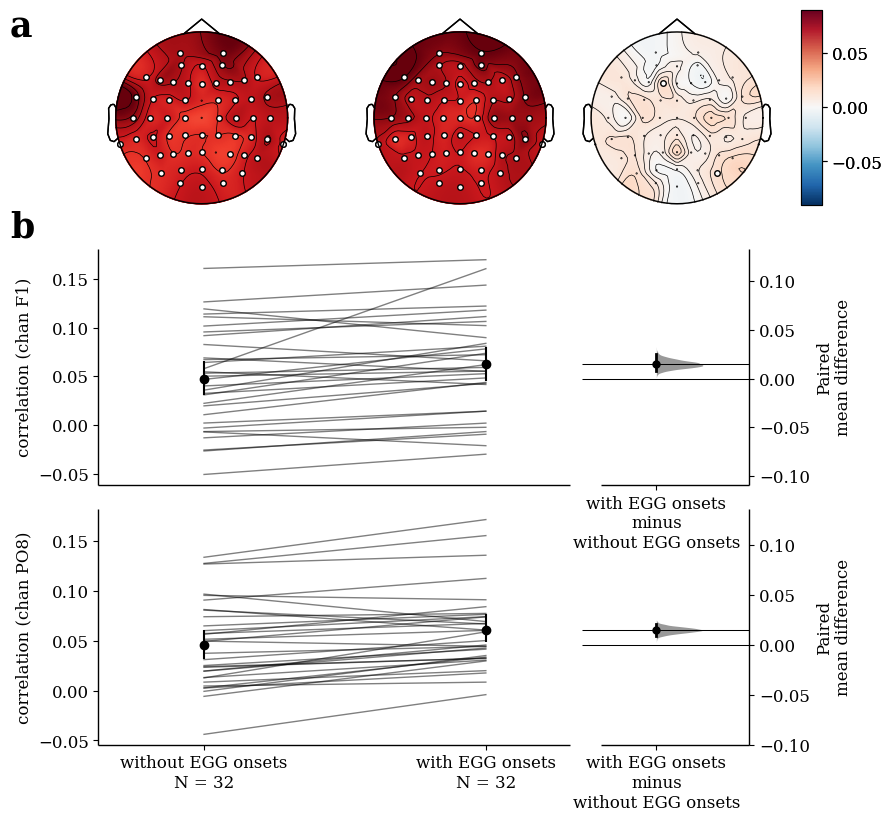

In [19]:
def add_label(ax, label, x_offset = -.19, y_offset = .1):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = 25, weight = 'bold'
    )

fig = plt.figure(figsize = (6, 9))
gs = gridspec.GridSpec(3, 2, wspace = .25, hspace = .1)

vlim = np.max([corrs_wo.max(), corrs_w.max(), corrs.max()])
ax = fig.add_subplot(gs[0, 0])
plot_topo(corrs_wo, p_wo, vlim, ax)
ax = fig.add_subplot(gs[0, 1])
plot_topo(corrs_w, p_w, vlim, ax)
ax = ax.inset_axes([1.05, 0, 1, 1])
img = plot_topo(corrs, p, vlim, ax)
cax = ax.inset_axes([1.1, 0, .1, 1])
plt.colorbar(img[0], cax)

axs = [fig.add_subplot(gs[i, :]) for i in range(1, len(chs) + 1)]
for i, ch in enumerate(chs):
    scr = scores[scores.channel == ch]
    plot_corrs(scr, axs[i])
    axs[i].set_ylabel('correlation (chan %s)'%ch)
    if i < len(chs) - 1:
        axs[i].set_xticks([])
        
add_label(axs[0], 'b', y_offset = .05)
add_label(axs[0], 'a', y_offset = .9)

vlim = np.max([corrs_wo.max(), corrs_w.max(), corrs.max()])
gs = gridspec.GridSpec(3, 2, wspace = .25, hspace = .1)
ax = fig.add_subplot(gs[0, 0])
plot_topo(corrs_wo, p_wo, vlim, ax)
ax = fig.add_subplot(gs[0, 1])
plot_topo(corrs_w, p_w, vlim, ax)
ax = ax.inset_axes([1.05, 0, 1, 1])
img = plot_topo(corrs, p, vlim, ax)
cax = ax.inset_axes([1.1, 0, .1, 1])
plt.colorbar(img[0], cax)

savefig('encoding.jpeg')
plt.show()

In [20]:
scr = pd.DataFrame([f.get_dict() for f in layout.get(desc = 'decoding', suffix = 'score')])
dfs = []
for col in scr.columns:
    df = pd.DataFrame({'out-of-sample correlation': scr[col].to_numpy(), 'feature': col})
    dfs.append(df)
df = pd.concat(dfs)
df.feature = df.feature.replace(dict(
    audioEnvelope = 'audio envelope',
    audioOnsets = 'audio onsets',
    eggEnvelope = 'EGG envelope',
    eggOnsets = 'EGG onsets'
))
df.head()

,out-of-sample correlation,feature
0,0.141872,audio envelope
1,0.222723,audio envelope
2,0.250060,audio envelope
3,0.404624,audio envelope
4,0.192816,audio envelope


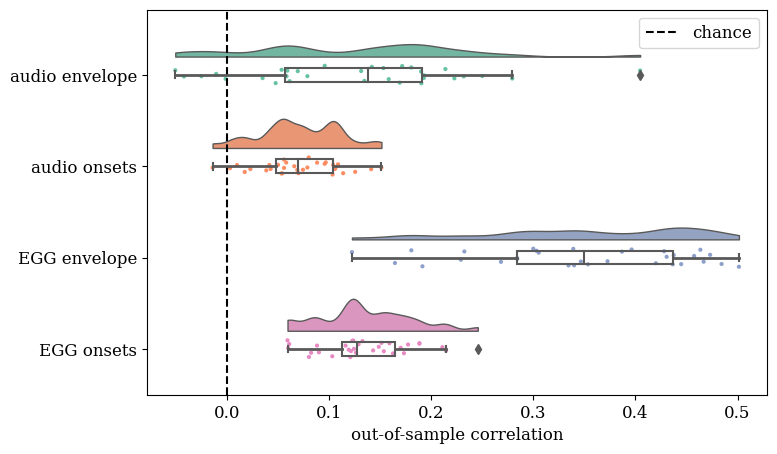

In [21]:
plt.figure(figsize = (8, 5))
pt.RainCloud(x = 'feature', y = 'out-of-sample correlation', data = df, orient = 'h')
plt.axvline(0, color = 'black', linestyle = '--', label = 'chance')
plt.ylabel(None)
plt.legend()

savefig('decoding.jpeg')
plt.show()

In [22]:
# test decoding performance against chance
t, p, _ = mne.stats.permutation_t_test(scr.to_numpy(), n_permutations = 10000, seed = 0)
print(p)

[0.0001 0.0001 0.0001 0.0001]


In [23]:
def get_patterns(mod, tp):
    tp = tp[0].upper() + tp[1:]
    evokeds_pat = [mne.read_evokeds(f.path)[0] for f in layout.get(desc = '%s%sPatterns'%(mod, tp))]
    patterns = mne.grand_average(evokeds_pat)
    return patterns

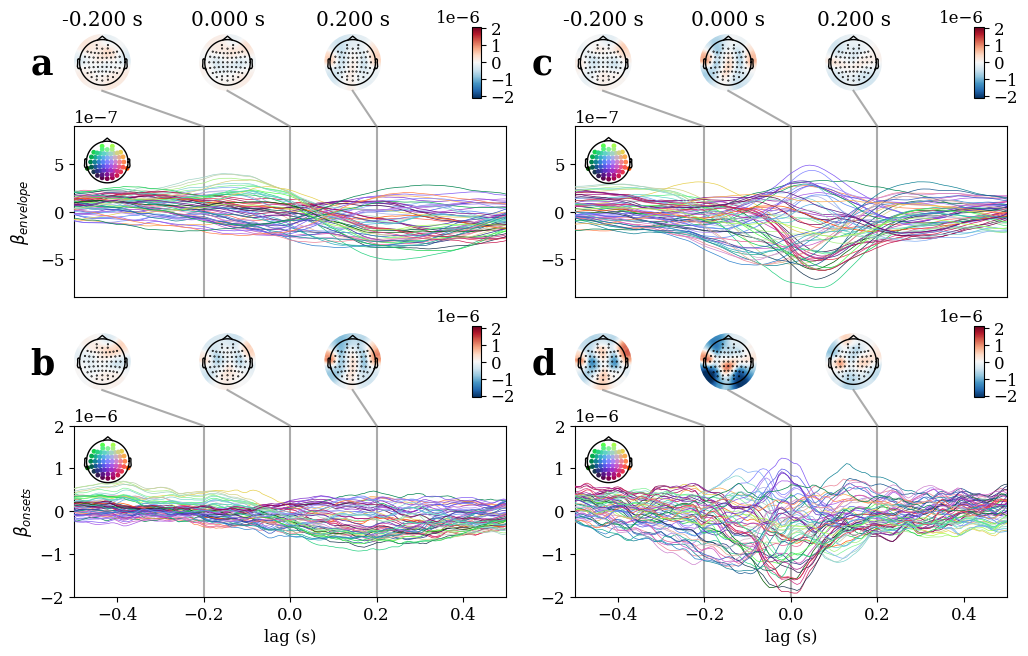

In [24]:
def plot_patterns(mod, tp, ts_ax, topo_axs):
    patterns = get_patterns(mod, tp)
    info = mne.create_info(patterns.ch_names, patterns.info['sfreq'], ch_types = 'eeg')
    patterns.info = info
    patterns.nave = None
    coords = get_elec_coords(as_mne_montage = True)
    patterns = patterns.set_montage(coords)
    if tp == 'envelope':
        ts_ax.set_ylim(-.9e-6, .9e-6)
    else:
        ts_ax.set_ylim(-2e-6, 2e-6)
    ts_args = dict(scalings = 1., units = r'$\beta_{%s}$'%tp, ylim = (-2e-6, 2e-6), axes = ts_ax)
    topo_args = dict(scalings = 1., vmin = -2.1e-6, vmax = 2.1e-6, contours = 0, axes = topo_axs)
    patterns.plot_joint(
        ts_args = ts_args, topomap_args = topo_args, 
        title = None, times = [-.2, 0, .2],
        show = False
    )
    ts_ax.set_xlabel('lag (s)')
    if tp == 'onsets':
        for ax in topo_axs[:-1]:
            ax.set_title('')
    else:
        ts_ax.set_xticks([])
        ts_ax.set_xlabel('')
    if mod == 'egg':
        ts_ax.set_ylabel('')

hspace = .4

fig = plt.figure(figsize = (10, 6))
gs = gridspec.GridSpec(6, 2*4, wspace = 1.2, hspace = hspace)
ts_ax = fig.add_subplot(gs[1:3, :4])
topo_axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
gs = gridspec.GridSpec(6, 2*40, wspace = .25, hspace = hspace)
topo_axs += [fig.add_subplot(gs[0, 34])] # smaller axis for colorbar
plot_patterns('audio', 'envelope', ts_ax, topo_axs)
add_label(ts_ax, 'a', x_offset = -.1, y_offset = .3)

gs = gridspec.GridSpec(6, 2*4, wspace = 1.2, hspace = hspace)
ts_ax = fig.add_subplot(gs[4:, :4])
topo_axs = [fig.add_subplot(gs[3, i]) for i in range(3)]
gs = gridspec.GridSpec(6, 2*40, wspace = .25, hspace = hspace)
topo_axs += [fig.add_subplot(gs[3, 34])] # smaller axis for colorbar
plot_patterns('audio', 'onsets', ts_ax, topo_axs)
add_label(ts_ax, 'b', x_offset = -.1, y_offset = .3)

gs = gridspec.GridSpec(6, 2*4, wspace = 1.2, hspace = hspace)
ts_ax = fig.add_subplot(gs[1:3, 4:])
topo_axs = [fig.add_subplot(gs[0, i]) for i in range(4, 7)]
gs = gridspec.GridSpec(6, 2*40, wspace = .25, hspace = hspace)
topo_axs += [fig.add_subplot(gs[0, -3])] # smaller axis for colorbar
plot_patterns('egg', 'envelope', ts_ax, topo_axs)
add_label(ts_ax, 'c', x_offset = -.1, y_offset = .3)

gs = gridspec.GridSpec(6, 2*4, wspace = 1.2, hspace = hspace)
ts_ax = fig.add_subplot(gs[4:, 4:])
topo_axs = [fig.add_subplot(gs[3, i]) for i in range(4, 7)]
gs = gridspec.GridSpec(6, 2*40, wspace = .25, hspace = hspace)
topo_axs += [fig.add_subplot(gs[3, -3])] # smaller axis for colorbar
plot_patterns('egg', 'onsets', ts_ax, topo_axs)
add_label(ts_ax, 'd', x_offset = -.1, y_offset = .3)

savefig('TRFs.jpeg')
plt.show()

In [25]:
f = layout.get(scope = 'clean', extension = 'fif.gz')[9]
epochs = mne.read_epochs(f.path, preload = True)
epochs = epochs.filter(70, None, picks = ['audio'])
epochs = epochs.filter(None, 30, picks = ['audio_envelope', 'egg_envelope'])

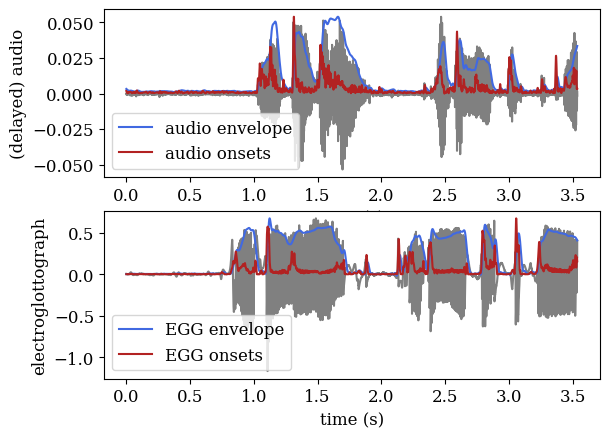

In [26]:
def plot_envelope(mod, ax):
    X = epochs['adaption'][15].get_data(picks = ['%s'%mod, '%s_envelope'%mod, '%s_onsets'%mod])
    X = np.squeeze(X)
    if mod == 'egg':
        mod = 'EGG'
    ax.plot(epochs.times, X[0], color = 'grey')
    ax.plot(
        epochs.times, X[1] * (X[0].max()/X[1].max()), 
        label = '%s envelope'%mod,
        color = 'royalblue'
    )
    ax.plot(
        epochs.times, X[2] * (X[0].max()/X[2].max()), 
        label = '%s onsets'%mod,
        color = 'firebrick'
    )
    ax.set_xlabel('time (s)')
    if mod == 'audio':
        mod = '(delayed) ' + mod
    else:
        mod = 'electroglottograph'
    ax.set_ylabel(mod)
    ax.legend()

fig, axs = plt.subplots(2, 1)
plot_envelope('audio', axs[0])
plot_envelope('egg', axs[1])

savefig('features.jpeg')
plt.show()